In [2]:
with open('../data/Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
words_list = [doc.strip().split() for doc in texts]

In [4]:
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


In [5]:
total_words = []
for words in words_list:
    total_words.extend(words)

In [6]:
from collections import Counter
c = Counter(total_words)

In [7]:
max_features = 10000
common_words = [ word for word, count in c.most_common(max_features)]
# 빈도를 기준으로 상위 10000개의 단어들만 선택

In [8]:
# 각 단어에 대해서 index 생성하기
words_dic ={}
for index, word in enumerate(common_words):
    words_dic[word]=index+1

In [9]:
# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

In [10]:
from tensorflow.keras.preprocessing import sequence
max_len = 40
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)

In [11]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)

In [13]:
len(y_test)

33077

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [15]:
model = models.Sequential()
model.add(layers.Embedding(max_features+1, 64, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(32), merge_mode='concat'))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            640064    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 665,026
Trainable params: 665,026
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint_filepath = './temp/checkpoint_bi_lstm_kr'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_weights_only=True, save_best_only=True)

In [17]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')

In [18]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[es, mc])

Epoch 1/20
931/931 [==============================] - 22s 21ms/step - loss: 0.3105 - accuracy: 0.8656 - val_loss: 0.2587 - val_accuracy: 0.8918
Epoch 2/20
931/931 [==============================] - 18s 19ms/step - loss: 0.2377 - accuracy: 0.9024 - val_loss: 0.2413 - val_accuracy: 0.9024
Epoch 3/20
931/931 [==============================] - 20s 21ms/step - loss: 0.2205 - accuracy: 0.9102 - val_loss: 0.2416 - val_accuracy: 0.9020
Epoch 4/20
931/931 [==============================] - 21s 22ms/step - loss: 0.2081 - accuracy: 0.9168 - val_loss: 0.2382 - val_accuracy: 0.9036
Epoch 5/20
931/931 [==============================] - 22s 23ms/step - loss: 0.1975 - accuracy: 0.9214 - val_loss: 0.2388 - val_accuracy: 0.9054
Epoch 6/20
931/931 [==============================] - 22s 24ms/step - loss: 0.1891 - accuracy: 0.9255 - val_loss: 0.2311 - val_accuracy: 0.9071
Epoch 7/20
931/931 [==============================] - 22s 24ms/step - loss: 0.1810 - accuracy: 0.9292 - val_loss: 0.2322 - val_accuracy:

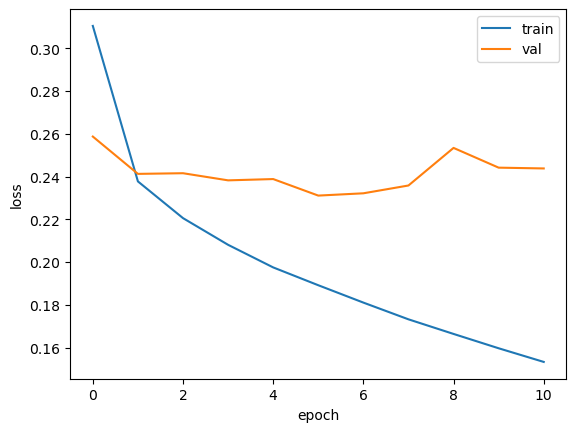

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [20]:
model.load_weights(checkpoint_filepath)

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_acc:', test_acc)

1034/1034 [==============================] - 4s 4ms/step - loss: 0.2300 - accuracy: 0.9076
test_acc: 0.907639741897583


In [22]:
model.predict(X_test[1:2])

1/1 [==============================] - 1s 513ms/step


array([[9.9995232e-01, 4.7621845e-05]], dtype=float32)

In [23]:
y_test[1]

array([1., 0.], dtype=float32)

In [24]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   42, 7585])

In [25]:
words_dict_reverse = dict((v,k) for k,v in words_dic.items())

In [26]:
def get_original_text(indexed_text):
    original_text = []
    for k in list(indexed_text):
        if k > 0:
            original_text.append(words_dict_reverse[k])
    return ' '.join(original_text)

In [27]:
get_original_text(X_test[1])

'대 실망 절정 이었'